# Trip Advisor Hotel Reviews - Sentiment Analysis
---

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Installs

In [2]:
!pip install -q -U --pre pycaret

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 481.8/481.8 kB 11.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 81.2/81.2 kB 7.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 212.2/212.2 kB 17.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 150.0/150.0 kB 12.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.8/105.8 kB 7.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 79.9/79.9 MB 6.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.8/45.8 kB 4.1 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.0/44.0 kB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 47.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.1/16.1 MB 53.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━

In [3]:
!pip install pycaret[nlp]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


# Imports

In [4]:
import pandas as pd
import matplotlib.pyplot as plt

from collections import Counter
import re

from sklearn.model_selection import train_test_split

from imblearn.over_sampling import SMOTE

import string

import spacy
from tqdm.auto import tqdm
import time
import os

# Data Loading

In [5]:
data =pd.read_csv("/content/drive/MyDrive/marrakech_hotels_reviews.csv")
data = data[['Review_Text','Review_Rating']]
# Mapping the review rating values to new values
rating_map = {50: 5, 40: 4, 30: 3, 20: 2, 10: 1}
data['Review_Rating'] = data['Review_Rating'].replace(rating_map)
data.columns = ['Review', 'Rating']
# remove duplicates based on "review" column
data = data.drop_duplicates(subset='Review', keep='first')

In [6]:
data.head()

,Review,Rating
0,I honestly couldn't fault Riad 72. The staff a...,5
1,We stayed for four nights at 72 Riad Living (w...,5
2,With a superb location it felt like an oasis a...,4
3,Beautifully designed Riad and perfect setting ...,5
4,Wow just simply delightful from the super tran...,5


In [7]:
data.tail()

,Review,Rating
55363,The hotel was the highlight of our stay. It is...,5
55364,Art Deco meets Marrakech....who would imagine!...,5
55365,I insisted on going to Marrakesh - it was my 3...,5
55366,We were whisked from the airport by Jaguar in ...,5
55367,My husband and I chose Marrakech as a weekend ...,5


In [8]:
import numpy as np
# filter rows with rating of 5
mask_5 = data['Rating'] == 5
mask_4 = data['Rating'] == 4

# randomly remove 5000 rows with rating of 5
remove_indices_5 = np.random.choice(data[mask_5].index, size=26498, replace=False)
remove_indices_4 = np.random.choice(data[mask_4].index, size=6000, replace=False)
data = data.drop(remove_indices_5)
data = data.drop(remove_indices_4)

In [9]:
len(data)

20000

# EDA

# Handling Null Values

In [10]:
data.isna().any()

Review    False
Rating    False
dtype: bool

In [11]:
data.isna().sum()

Review    0
Rating    0
dtype: int64

In [12]:
data.shape

(20000, 2)

# Handling Duplicate Values

In [13]:
data.nunique().any()

True

In [14]:
data.nunique()

Review    20000
Rating        5
dtype: int64

# Preprocessing the Text

In [15]:
# Load the English NLP model
nlp = spacy.load('en_core_web_sm')

# Define stop words
stop_words = spacy.lang.en.stop_words.STOP_WORDS

In [16]:
nlp

In [17]:
def preprocess_text(text):
    # Parse the text with Spacy
    doc = nlp(text)
    
    # Lemmatize the tokens and remove stop words
    lemmas = [token.lemma_.lower() for token in doc if not token.is_stop]
    
    # Join the lemmas back into a string and return it
    return " ".join(lemmas)

In [18]:
%%time

tqdm.pandas()

data['Review'] = data['Review'].progress_apply(preprocess_text)

  0%|          | 0/20000 [00:00<?, ?it/s]

CPU times: user 16min 54s, sys: 10.7 s, total: 17min 4s
Wall time: 17min 48s


In [19]:
def preprocess_signs(text):
    # Remove URLs
    text = re.sub(r'http\S+', '', text)

    # Remove mentions and hashtags
    text = re.sub(r'@\w+|#\w+', '', text)

    # Remove punctuation and convert to lowercase
    text = text.translate(str.maketrans('', '', string.punctuation)).lower()

    # Remove extra whitespace
    text = re.sub('\s+', ' ', text).strip()

    return text

In [20]:
data['Review'] = data['Review'].apply(preprocess_signs)

In [21]:
# Save the processed DataFrame as a CSV file
data.to_csv('/content/drive/MyDrive/processed_data.csv', index=False)

# Commonly Used Words

In [22]:
import matplotlib.pyplot as plt
from collections import Counter
import re

import nltk
from nltk.corpus import stopwords

In [23]:
# Concatenate all tweet texts into a single string
all_text = ' '.join(data['Review'].values)

In [24]:
# Split the text into individual words
words = all_text.split()

In [25]:
import nltk
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

In [26]:
# Remove stop words
stop_words = set(stopwords.words('english'))
words = [word for word in words if not word in stop_words]

In [27]:
# Count the frequency of each word
word_counts = Counter(words)

In [28]:
top_words = word_counts.most_common(50)
top_words

[('hotel', 47108),
 ('room', 33824),
 ('staff', 24206),
 ('good', 21992),
 ('pool', 21623),
 ('food', 19331),
 ('day', 17818),
 ('stay', 17529),
 ('time', 14511),
 ('great', 12530),
 ('restaurant', 11834),
 ('night', 11045),
 ('bar', 10454),
 ('service', 10307),
 ('nice', 10216),
 ('go', 9395),
 ('clean', 9367),
 ('like', 8873),
 ('drink', 8852),
 ('lovely', 7753),
 ('area', 7615),
 ('breakfast', 7355),
 ('people', 7262),
 ('reception', 7208),
 ('want', 7172),
 ('place', 7161),
 ('find', 7125),
 ('friendly', 7046),
 ('need', 6903),
 ('holiday', 6876),
 ('come', 6845),
 ('marrakech', 6807),
 ('get', 6677),
 ('book', 6500),
 ('bed', 6475),
 ('ask', 6460),
 ('water', 6135),
 ('work', 5969),
 ('look', 5882),
 ('feel', 5844),
 ('take', 5740),
 ('2', 5652),
 ('lot', 5595),
 ('entertainment', 5588),
 ('leave', 5569),
 ('pay', 5569),
 ('walk', 5553),
 ('5', 5440),
 ('recommend', 5404),
 ('evening', 5341)]

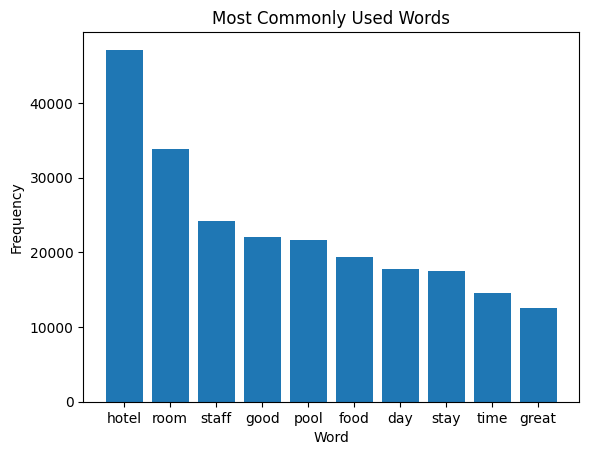

In [29]:
# Create a bar chart of the most common words
top_words = word_counts.most_common(10) # Change the number to show more/less words
x_values = [word[0] for word in top_words]
y_values = [word[1] for word in top_words]
plt.bar(x_values, y_values)
plt.xlabel('Word')
plt.ylabel('Frequency')
plt.title('Most Commonly Used Words')
plt.show()

# Converting Text into Numerical Features / Vectorization

In [30]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(data['Review'])
y = data['Rating']

# Class Distributions

In [31]:
# Count the number of instances in each class
class_counts = data['Rating'].value_counts()

# Print the class distribution
print('Ratings distribution:')
print(class_counts)

Ratings distribution:
5    7317
4    4856
3    4310
2    1767
1    1750
Name: Rating, dtype: int64


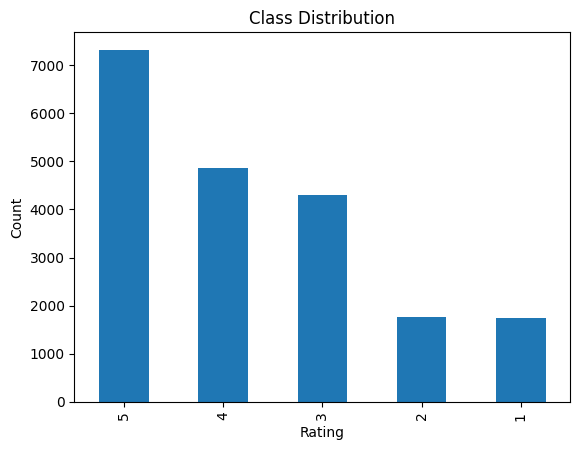

In [32]:
class_counts.plot.bar()
plt.title('Class Distribution')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

# ML Models

In [33]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [34]:
print("X Train : ", X_train.shape)
print("X Test  : ", X_test.shape)
print("Y Train : ", y_train.shape)
print("Y Test  : ", y_test.shape)

X Train :  (16000, 38634)
X Test  :  (4000, 38634)
Y Train :  (16000,)
Y Test  :  (4000,)


In [39]:
#Importing the basic librarires for building model - classification

from sklearn.model_selection import train_test_split

from sklearn.metrics import accuracy_score,r2_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error


from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import  KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.neural_network import  MLPClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.naive_bayes import MultinomialNB

from sklearn.feature_extraction.text import CountVectorizer

from sklearn.preprocessing import LabelEncoder,StandardScaler
import joblib


In [36]:
#Defined object from library classification 

LR = LogisticRegression()
RFR = RandomForestClassifier()
KNR = KNeighborsClassifier()
SVM = SVC()
NB = MultinomialNB()

In [37]:
# make for loop for classification 

li = [LR,RFR,KNR,SVM,NB]
d = {}
for model in li:
    model.fit(X_train,y_train)
    ypred = model.predict(X_test)
    print(model,":",accuracy_score(y_test,ypred)*100)
    d.update({str(model):model.score(X_test,y_test)*100})
    
    # Save the trained model to a file
    filename = str(model) + '.joblib'
    file_path = os.path.join('/content/drive/MyDrive/', filename)
    joblib.dump(model, file_path)

/usr/local/lib/python3.9/dist-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


LogisticRegression() : 63.449999999999996
RandomForestClassifier() : 54.474999999999994
KNeighborsClassifier() : 50.575
SVC() : 64.325
MultinomialNB() : 54.55


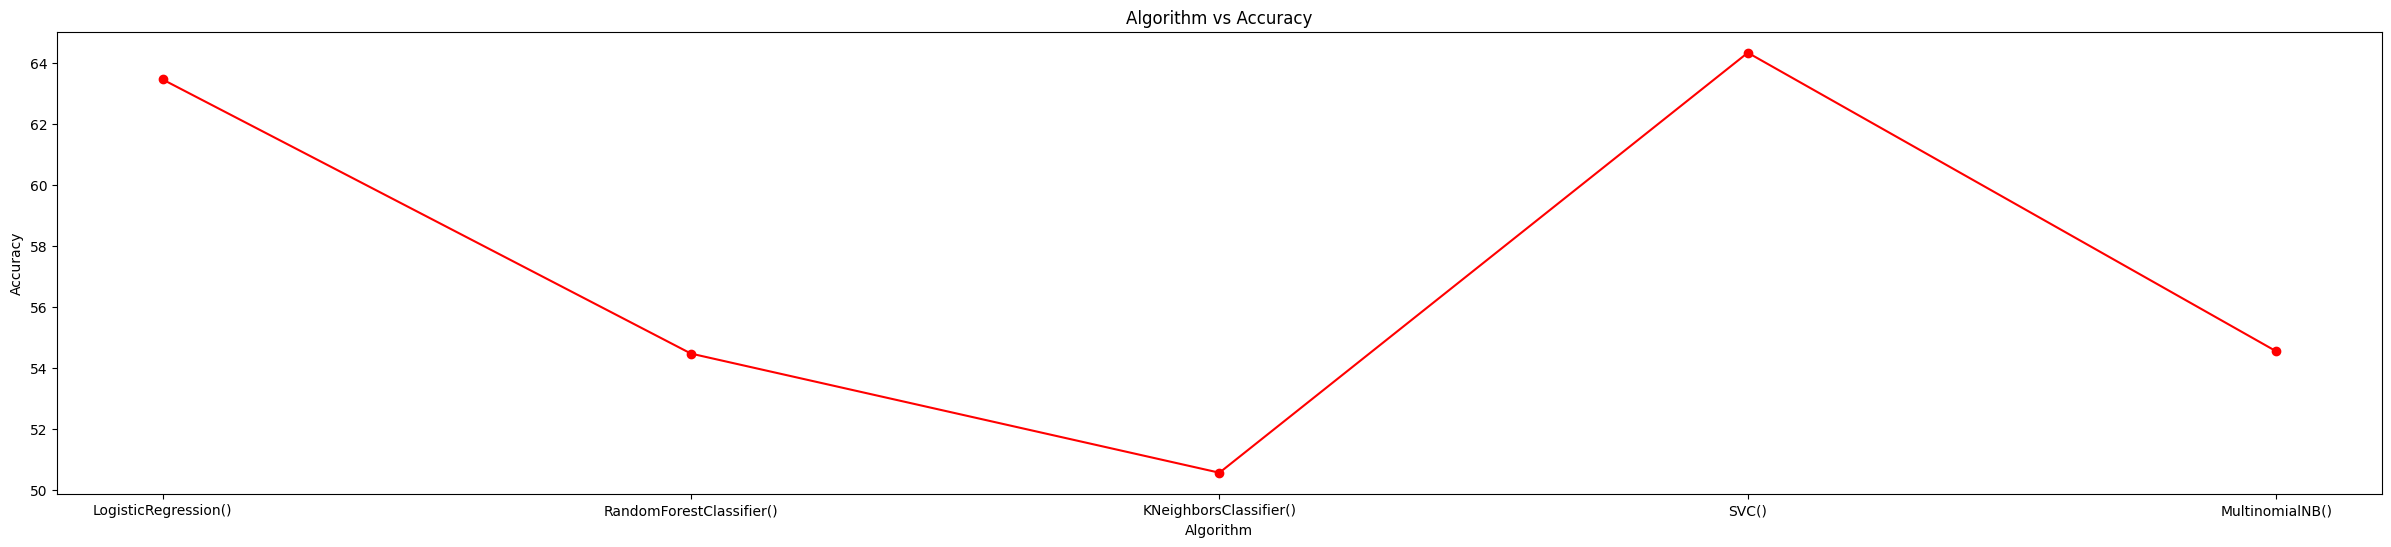

In [38]:
# make graph about Accuracy
plt.figure(figsize=(30, 6))
plt.title("Algorithm vs Accuracy")
plt.xlabel("Algorithm")
plt.ylabel("Accuracy")
plt.plot(d.keys(),d.values(),marker='o',color='red')
plt.show()

In [46]:
# Load a saved model from a file
filename = 'LogisticRegression().joblib'
file_path = os.path.join('/content/drive/MyDrive/', filename)
LogisticRegression = joblib.load(file_path)
pred = LogisticRegression.predict(X_test)

In [47]:
print('Accuracy: {}'.format(accuracy_score(pred, y_test)))
print("Mean absolute error: {}".format(mean_absolute_error(pred,y_test)))
print("Root mean square error: {}".format(np.sqrt(mean_squared_error(pred,y_test))))


Accuracy: 0.6345
Mean absolute error: 0.44525
Root mean square error: 0.7976528066771909


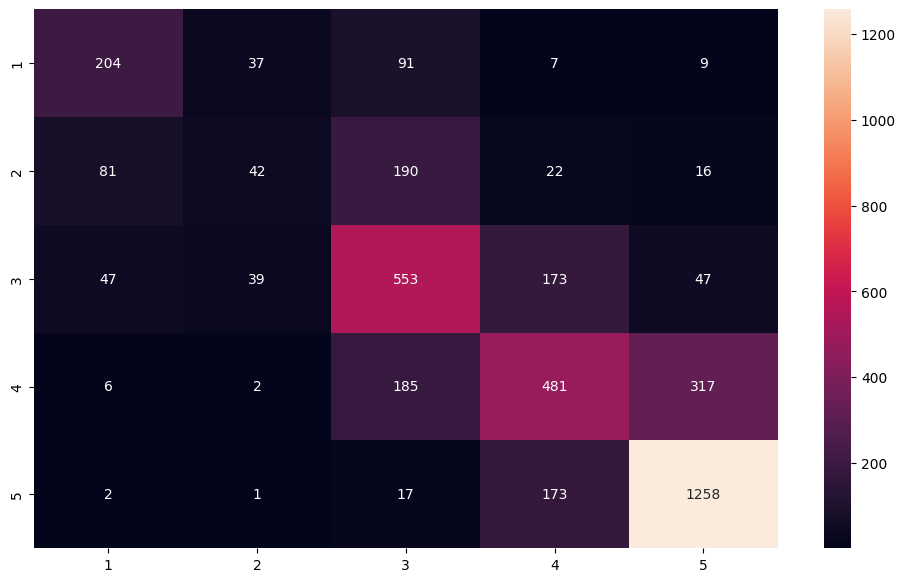

In [44]:
import seaborn as sns

labels = ['1', '2', '3', '4', '5']
conf = confusion_matrix(y_test, pred)

cm = pd.DataFrame(
    conf, index = [i for i in labels],
    columns = [i for i in labels]
)

plt.figure(figsize = (12,7))
sns.heatmap(cm, annot=True, fmt="d")
plt.show()

In [45]:
print(classification_report(y_test, pred, target_names=labels))

              precision    recall  f1-score   support

           1       0.60      0.59      0.59       348
           2       0.35      0.12      0.18       351
           3       0.53      0.64      0.58       859
           4       0.56      0.49      0.52       991
           5       0.76      0.87      0.81      1451

    accuracy                           0.63      4000
   macro avg       0.56      0.54      0.54      4000
weighted avg       0.61      0.63      0.62      4000

